In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-pollution-dataset/pollution_raw.csv


In [60]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
df = pd.read_csv('/kaggle/input/air-pollution-dataset/pollution_raw.csv')

In [28]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [29]:
df.shape

(43824, 13)

In [30]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [31]:
df.duplicated().sum()

0

In [32]:
# from pandas import read_csv
# from datetime import datetime
# # load data
# def parse(x):
# 	return datetime.strptime(x, '%Y %m %d %H')
# dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset.drop('No', axis=1, inplace=True)
# # manually specify column names
# dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# dataset.index.name = 'date'
# # mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# # drop the first 24 hours
# dataset = dataset[24:]
# # summarize first 5 rows
# print(dataset.head(5))
# # save to file
# dataset.to_csv('pollution.csv')

# converting year,month,day,hour column to a single datetime column

In [33]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
#settin datetime coloumn as index column
df.set_index('datetime', inplace=True)

In [34]:
df.head(1)
df.drop(columns=['No'],inplace=True)

# Changin columns names 

In [35]:
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [36]:
df.head(1)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-01,NaN,-21,-11.0,1021.0,NW,1.79,0,0


In [37]:
df = df[24:]

In [38]:
df.shape
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


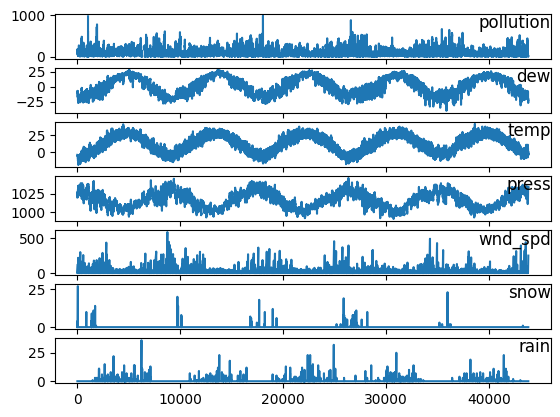

In [39]:


from matplotlib import pyplot
# load dataset

values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(df.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

# Converting time series data to supervised learning data

In [41]:
# Set the first row as header
df.columns = df.iloc[0]

In [42]:
values = df.values

In [43]:
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

# Encoding values

In [44]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
values[:,4] = lb.fit_transform(values[:,4])

In [45]:
# ensure all data is float
values = values.astype('float32')

In [46]:
# normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [53]:
def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols,names = list(),list()
    #creating input variable(to be trained) from time step(t-n,...t-1)
    #i.e creating lag features and appending to cols list and appending names of lags features
    #var1(t-1)
    
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [54]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [55]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [56]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [63]:
...
# split into train and test sets
values = reframed.values
n_train_hours = 3 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (15263, 1, 8) (15263,)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 - 3s - 8ms/step - loss: 0.0407 - val_loss: 0.0442
Epoch 2/50
365/365 - 2s - 6ms/step - loss: 0.0165 - val_loss: 0.0172
Epoch 3/50
365/365 - 1s - 4ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 4/50
365/365 - 1s - 3ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 5/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 6/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 7/50
365/365 - 1s - 4ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 8/50
365/365 - 1s - 4ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 9/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 10/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 11/50
365/365 - 1s - 3ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 12/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 13/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 14/50
365/365 - 1s - 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 15/50
365/365 - 1s - 3ms/step - lo

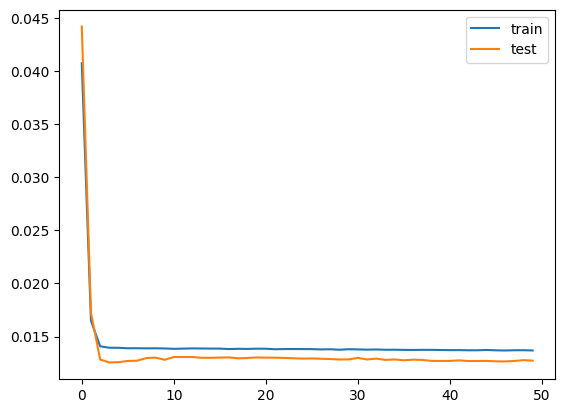

In [64]:
...
from keras.models import Sequential

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [65]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test RMSE: 21.387
